### (1) Imports, paths, and config

In [1]:
import sys
import os
from os import environ
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

In [2]:
# Change twhit to your username
os.chdir('/home/twhit/bliss/case_studies/weak_lensing/')

# Compose lensing_config.yaml
with initialize(config_path="../", version_base=None):
    cfg = compose("lensing_config", overrides={"surveys.sdss.load_image_data=true"})

We now have a lensing-specific config that uses a lensing-specific prior and simulator. You can check it out in `lensing_config.yaml`. This lensing_config pulls from `bliss/conf/base_config.yaml`. For now, there are only a few things we need to change in the config to incorporate our lensing parameters.

---

### (2) Changes to the prior

If you look in `lensing_prior.py`, you'll see that I created a new subclass of `CatalogPrior` called `LensingPrior`. This lensing prior is the target of the new lensing config printed above. The number of tiles, tile side length, and batch size are all the same as the base config, but I changed `prob_galaxy` so that we generate all galaxies and no stars.

In `LensingPrior`, I overrode the `__init__` method to add hyperparameters for the shear and convergence priors:
```
def __init__(
        self,
        *args,
        shear_min: float,
        shear_max: float,
        convergence_a: float,
        convergence_b: float,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.shear_min = shear_min
        self.shear_max = shear_max
        self.convergence_a = convergence_a
        self.convergence_b = convergence_b
```

As we discussed in the .tex file for the generative model, we're going to assume a `Uniform(shear_min, shear_max)` prior for each component of shear in each tile, and a `Beta(a,b)` prior for the convergence in each tile.

We also added two methods called `_sample_shear` and `_sample_convergence` to `LensingPrior`, and we've overridden the `sample` method so it includes `_sample_shear` and `_sample_convergence`.

---

### (3) Changes to the decoder

I created a subclass of `ImageDecoder` called `LensingDecoder`. The only thing we need to update is the `render_galaxy` method. We'll take the shear and convergence that we sample from the prior for each tile and plug them into GalSim's `lens` method to alter the shape and brightness of each galaxy in that tile.

Here are the new parts of `render_galaxy`:

```
shear = source_params["shear"]
shear1, shear2 = shear
convergence = source_params["convergence"]

reduced_shear1 = shear1 / (1 - convergence)
reduced_shear2 = shear2 / (1 - convergence)
magnification = 1 / ((1 - convergence) ** 2 - shear1**2 - shear2**2)

.
.
.

lensed_galaxy = galaxy.lens(
    g1=reduced_shear1.item(), g2=reduced_shear2.item(), mu=magnification.item()
)
```

---

### (4) Changes to the simulator

I copied the `SimulatedDataset` class in `bliss/simulator/simulated_dataset.py` into a new class called `LensingSimulatedDataset`. You can find this new class in `lensing_simulated_dataset.py`. It's basically the same as the original class except it refers to the lensing prior and the lensing decoder instead of the non-lensing versions.

---

### (5) Generating images

We can now generate images in basically the same way as `example.ipynb`, except now we're drawing from the lensing prior. This means that galaxies will be rendered with shear and convergence.

Let's get a batch of 32 images:

In [3]:
simulated_dataset = instantiate(cfg.simulator)

batch = simulated_dataset.get_batch()

We can see that shear and convergence are now in the tile catalogs:

In [4]:
# Shear and convergence are now in the tile catalog
tile_catalogs = batch['tile_catalog']
tile_catalogs.keys()

dict_keys(['locs', 'n_sources', 'shear', 'convergence', 'source_type', 'galaxy_fluxes', 'galaxy_params', 'star_fluxes'])

Here's the r-band of the first few images in the batch (80 pixels by 80 pixels), as well as the corresponding shear1 maps, shear2 maps, and convergence maps (which are all 20 tiles by 20 tiles):

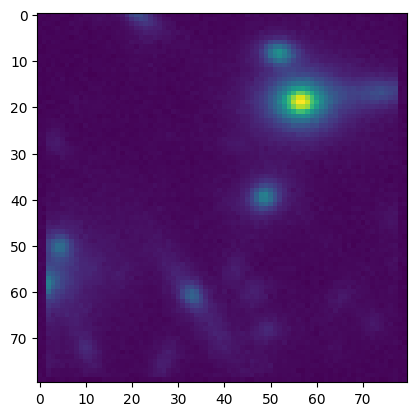

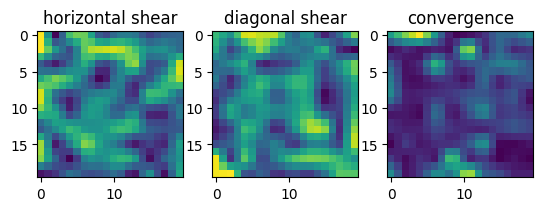

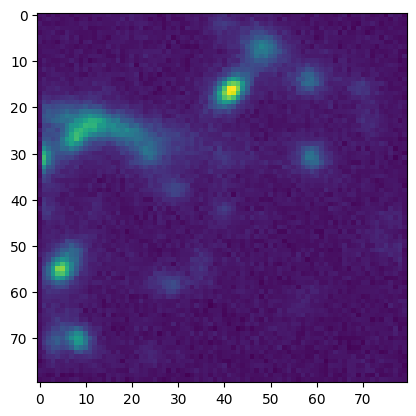

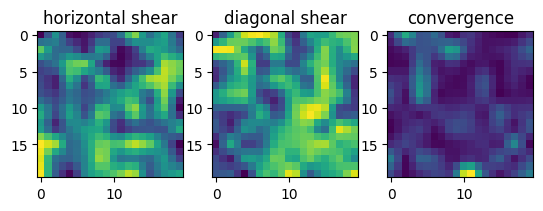

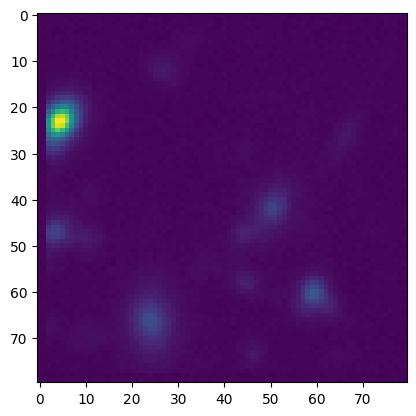

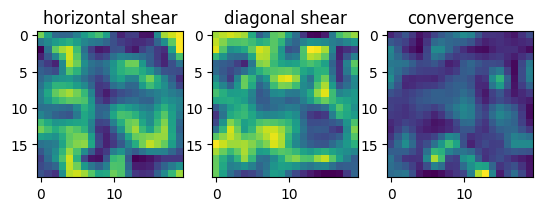

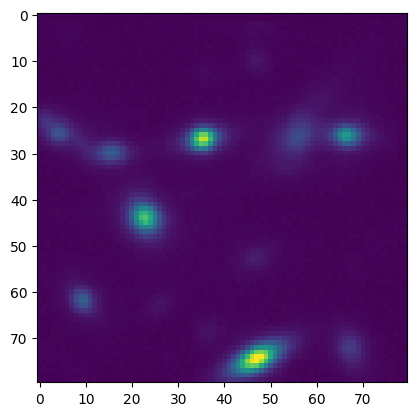

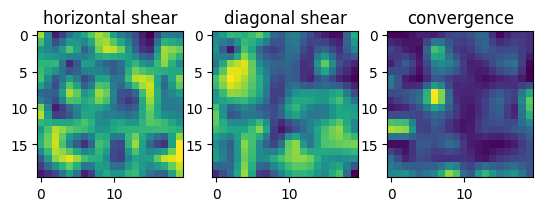

In [5]:
for j in range(4):
    # r-band
    fig, img = plt.subplots(nrows=1, ncols=1)
    _ = plt.imshow(batch['images'][j][2])

    # shear1 (horizontal) map
    fig, (map1, map2, map3) = plt.subplots(nrows=1, ncols=3)
    _ = map1.imshow(tile_catalogs['shear'][j].squeeze()[:,:,0])
    _ = map1.set_title('horizontal shear')

    # shear2 (diagonal) map
    _ = map2.imshow(tile_catalogs['shear'][j].squeeze()[:,:,1])
    _ = map2.set_title('diagonal shear')

    # convergence map
    _ = map3.imshow(tile_catalogs['convergence'][j].squeeze())
    _ = map3.set_title('convergence')